# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




# Import Libraries

In [21]:
import warnings
import csv
import numpy as np
import pandas as pd
import scipy

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199

# Plotting
from matplotlib import pyplot as plt
from IPython.display import display

# Metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics

# Model/Feature selection
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel, RFECV,  chi2, SelectKBest, f_classif, mutual_info_classif, f_regression

# Pipeline
from sklearn.pipeline import make_pipeline, Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Projection
from sklearn.decomposition import PCA
import sklearn.manifold
import umap.umap_ as umap

# Scaling
from sklearn.preprocessing import StandardScaler

# Load data

In [3]:
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

# Defining Models and Cross Validation Scheme

In [4]:
models = [
          ('LogReg', LogisticRegression()), 
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC(kernel='linear')), 
        ]
rfecv_models = [
                ('LogReg', LogisticRegression()),
                ('SVM', SVC(kernel='linear'))
               ]
scaler = StandardScaler()
kf = KFold(n_splits=18, shuffle=False)

In [5]:
#Check if model is overfitting:
trains = []
tests = []
#model = KNeighborsClassifier() 
#model = LogisticRegression(C=0.05)
model = SVC(kernel='linear')   
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Applying Scaling
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    y_p_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_p_train)
    y_p_test = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_p_test)
    trains.append(train_acc)
    tests.append(test_acc)
print(np.mean(trains))
print(np.mean(tests))
print(trains)
print(tests)

1.0
0.8999999999999999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 0.9, 1.0, 0.8, 0.8, 0.9, 0.9]


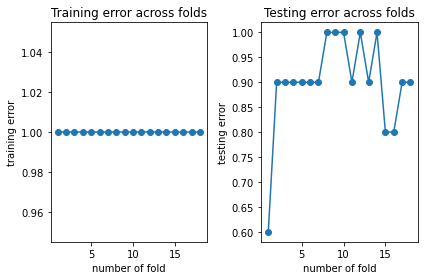

In [6]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(trains).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(tests).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('testing error')
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

# Evaluation Functions

In [7]:
def evaluate(models, data, kf):
    results = []
    for name, model in models:
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        # train loop
        for train_index, test_index in kf.split(data):
            #data = scaler.fit_transform(data)
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]
            #Applying Scaling
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": name,
            "mean_accuracy": np.mean(accuracy),
            "std_accuracy": np.std(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [8]:
def evaluate_model(model, data, kf):
    results = []
    sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
    # train loop
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #Applying Scaling
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_model_predict = model.predict(X_test)
        y_pred.extend(y_model_predict)
        y_true.extend(y_test)
        accuracy.append(accuracy_score(y_test, y_model_predict))
    # calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    auc = roc_auc_score(y_true, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    res = {
        "model": name,
        "mean_accuracy": np.mean(accuracy),
        "std_accuracy": np.std(accuracy),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": auc,
    }
    results.append(res)
    return pd.DataFrame.from_dict(results)

In [9]:
def lasso_evaluation(model, X, y, kf, alpha_space):
    results = []
    for alpha in alpha_space:
        model.named_steps['lt'].alpha = alpha
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        feature_size = model.named_steps['lt'].transform(X_train).shape[1]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": type(model.steps[2][1]).__name__,
            "accuracy": np.mean(accuracy),
            "std_accuracy": np.std(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
            "feature_size": feature_size
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [10]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

# Baseline Benchmark with scaling.

In [11]:
results = evaluate(models, X, kf)
results

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.933333,0.081650,0.9250,0.94,0.93250
1,KNN,0.855556,0.106574,0.7875,0.91,0.84875
2,SVM,0.900000,0.094281,0.9000,0.90,0.90000


# Removing highly correlated features

In [12]:
X_corr = corr_df(pd.DataFrame(X), 0.9)
X_corr = X_corr.to_numpy()
X_corr.shape

(180, 256)

# Performance after removing correlated features

In [13]:
results = evaluate(models, X_corr, kf)
results

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.883333,0.130171,0.8625,0.90,0.88125
1,KNN,0.872222,0.104379,0.7875,0.94,0.86375
2,SVM,0.877778,0.135628,0.8625,0.89,0.87625


# Using RFECV to find optimal value of K on Scaled dataset

Optimal number of features : 43


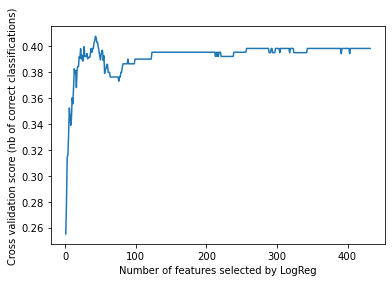

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.916667,0.083333,0.925,0.91,0.9175


Optimal number of features : 322


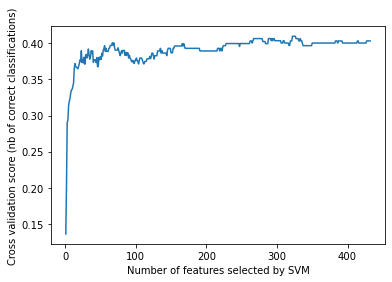

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.916667,0.095743,0.8875,0.94,0.91375


In [14]:
for name, model in rfecv_models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X), scoring='f1', n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_data = X[:,features]  
    rfecv_results = evaluate_model(model, rfecv_data, kf)
    display(rfecv_results)

Optimal number of features : 262


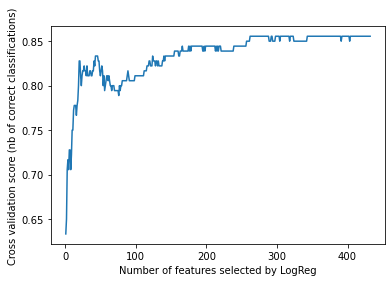

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.933333,0.08165,0.9125,0.95,0.93125


Optimal number of features : 322


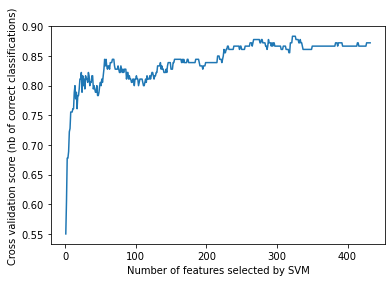

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.916667,0.095743,0.8875,0.94,0.91375


In [15]:
for name, model in rfecv_models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_data = X[:,features]  
    rfecv_results = evaluate_model(model, rfecv_data, kf)
    display(rfecv_results)

# RFECV on Correlation dataset.

Optimal number of features : 37


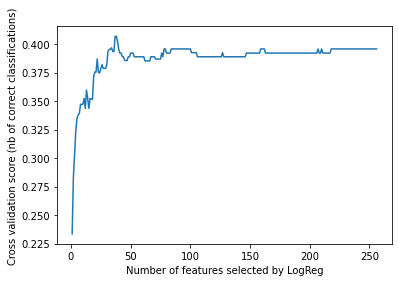

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.905556,0.097024,0.875,0.93,0.9025


Optimal number of features : 43


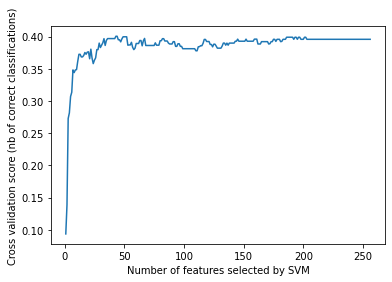

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.933333,0.094281,0.9375,0.93,0.93375


In [16]:
for name, model in rfecv_models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X_corr), scoring='f1', n_jobs=-1)
    rfecv.fit(X_corr, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_corr_data = X_corr[:,features]  
    rfecv_results = evaluate_model(model, rfecv_corr_data, kf)
    display(rfecv_results)

# Pearson correlation

In [ ]:
# We take pearson correlation with the input columns and output labels

def score_pearson_all(X, y):
    dfX = pd.DataFrame(X)
    # PearsonR gives the pearson coefficient and the p value
    return np.array([scipy.stats.pearsonr(dfX[c], y) for c in dfX.columns])

def score_pearson(X, y):
    # only using pvalue
    return score_pearson_all(X, y)[:,1]



In [19]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(score_pearson, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    pearson = SelectKBest(score_pearson, k = best_k_value) 
    pearson_data = pearson.fit_transform(X, y)
    features = pearson.get_support(indices=True)
    pearson_data = X[:,features]  
    pearson_results = evaluate_model(model, pearson_data, kf)
    display(pearson_results)

Number of feature selected:  404


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.916667,0.068718,0.9,0.93,0.915


Number of feature selected:  424


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,KNN,0.866667,0.105409,0.8125,0.91,0.86125


Number of feature selected:  398


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.911111,0.093624,0.8875,0.93,0.90875


# Chi-squared test on scaled dataset

In [25]:
for name, model in rfecv_models:
    clf = Pipeline([('skb', SelectKBest(chi2, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    chi_squared = SelectKBest(chi2, k = best_k_value) 
    chi_squared_data = chi_squared.fit_transform(X, y)
    features = chi_squared.get_support(indices=True)
    chi_squared_data = X[:,features]  
    chi_squared_results = evaluate_model(model, chi_squared_data, kf)
    display(chi_squared_results)

Number of feature selected:  328


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.922222,0.078567,0.9,0.94,0.92


Number of feature selected:  205


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.905556,0.070492,0.9,0.91,0.905


In [26]:
for name, model in rfecv_models:
    clf = Pipeline([('skb', SelectKBest(chi2, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    chi_squared = SelectKBest(chi2, k = best_k_value) 
    chi_squared_data = chi_squared.fit_transform(X, y)
    features = chi_squared.get_support(indices=True)
    chi_squared_data = X[:,features]  
    chi_squared_results = evaluate_model(model, chi_squared_data, kf)
    display(chi_squared_results)

Number of feature selected:  314


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.916667,0.089753,0.8875,0.94,0.91375


Number of feature selected:  304


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.922222,0.071146,0.925,0.92,0.9225


# ANOVA filter method on scaled dataset.

In [56]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(f_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    anova = SelectKBest(f_classif, k = best_k_value) 
    anova_data = anova.fit_transform(X, y)
    features = anova.get_support(indices=True)
    anova_data = X[:,features]  
    anova_results = evaluate_model(model, anova_data, kf)
    display(anova_results)

Number of feature selected:  182


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.911111,0.093624,0.875,0.94,0.9075


Number of feature selected:  392


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,KNN,0.855556,0.101227,0.8,0.9,0.85


Number of feature selected:  151


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.877778,0.131468,0.85,0.9,0.875


In [57]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(f_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    anova = SelectKBest(f_classif, k = best_k_value) 
    anova_data = anova.fit_transform(X, y)
    features = anova.get_support(indices=True)
    anova_data = X[:,features]  
    anova_results = evaluate_model(model, anova_data, kf)
    display(anova_results)

Number of feature selected:  369


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.938889,0.089062,0.9125,0.96,0.93625


Number of feature selected:  391


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,KNN,0.855556,0.101227,0.8,0.9,0.85


Number of feature selected:  149


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.883333,0.134371,0.8625,0.9,0.88125


# Mutual Information filter method on scaled dataset.

In [58]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
    mutual_info_data = mutual_info.fit_transform(X, y)
    features = mutual_info.get_support(indices=True)
    mutual_info_data = X[:,features] 
    mutual_info_results = evaluate_model(model, mutual_info_data, kf)
    display(mutual_info_results)

Number of feature selected:  161


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.938889,0.075564,0.9125,0.96,0.93625


Number of feature selected:  131


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,KNN,0.861111,0.059056,0.85,0.87,0.86


Number of feature selected:  231


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.944444,0.059835,0.9375,0.95,0.94375


In [59]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
    mutual_info_data = mutual_info.fit_transform(X, y)
    features = mutual_info.get_support(indices=True)
    mutual_info_data = X[:,features] 
    mutual_info_results = evaluate_model(model, mutual_info_data, kf)
    display(mutual_info_results)

Number of feature selected:  181


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.927778,0.073072,0.9125,0.94,0.92625


Number of feature selected:  151


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,KNN,0.855556,0.068493,0.825,0.88,0.8525


Number of feature selected:  221


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.944444,0.059835,0.95,0.94,0.945


# Lasso embedded method feature selection on scaled dataset.

In [60]:
model = LassoCV(cv=kf.split(X))
model.fit(X, y)

LassoCV(cv=<generator object _BaseKFold.split at 0x000002BD0B49CD60>)

In [61]:
model.alphas_

array([0.8335218 , 0.77734522, 0.72495475, 0.67609523, 0.63052867,
       0.58803315, 0.54840168, 0.51144125, 0.47697182, 0.44482551,
       0.41484576, 0.38688655, 0.36081169, 0.33649419, 0.31381561,
       0.29266548, 0.27294081, 0.25454551, 0.23739   , 0.22139071,
       0.20646971, 0.19255435, 0.17957683, 0.16747395, 0.15618677,
       0.1456603 , 0.13584328, 0.1266879 , 0.11814956, 0.11018668,
       0.10276046, 0.09583475, 0.08937581, 0.08335218, 0.07773452,
       0.07249548, 0.06760952, 0.06305287, 0.05880331, 0.05484017,
       0.05114412, 0.04769718, 0.04448255, 0.04148458, 0.03868865,
       0.03608117, 0.03364942, 0.03138156, 0.02926655, 0.02729408,
       0.02545455, 0.023739  , 0.02213907, 0.02064697, 0.01925543,
       0.01795768, 0.0167474 , 0.01561868, 0.01456603, 0.01358433,
       0.01266879, 0.01181496, 0.01101867, 0.01027605, 0.00958348,
       0.00893758, 0.00833522, 0.00777345, 0.00724955, 0.00676095,
       0.00630529, 0.00588033, 0.00548402, 0.00511441, 0.00476

In [62]:
alpha_space = [0.1456603 , 0.13584328, 0.1266879 , 0.11814956, 0.11018668,
       0.10276046, 0.09583475, 0.08937581, 0.08335218, 0.07773452,
       0.07249548, 0.06760952, 0.06305287, 0.05880331, 0.05484017,
       0.05114412, 0.04769718, 0.04448255, 0.04148458, 0.03868865,
       0.03608117, 0.03364942, 0.03138156, 0.02926655, 0.02729408,
       0.02545455, 0.023739  , 0.02213907, 0.02064697, 0.01925543,
       0.01795768, 0.0167474 , 0.01561868, 0.01456603, 0.01358433,
       0.01266879, 0.01181496, 0.01101867, 0.01027605, 0.00958348,
       0.00893758, 0.00833522, 0.00777345, 0.00724955, 0.00676095,
       0.00630529, 0.00588033, 0.00548402, 0.00511441, 0.00476972,
       0.00444826, 0.00414846, 0.00386887, 0.00360812, 0.00336494,
       0.00313816, 0.00292665, 0.00272941, 0.00254546, 0.0023739 ,
       0.00221391, 0.0020647 , 0.00192554, 0.00179577, 0.00167474,
       0.00156187, 0.0014566 , 0.00135843, 0.00126688, 0.0011815 ,
       0.00110187, 0.0010276 , 0.00095835, 0.00089376, 0.00083352]

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
class LassoTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, alpha):
        self.alpha = alpha
        pass

    def fit(self, X, y):
        lasso = Lasso(alpha=self.alpha, fit_intercept=False, random_state=0)
        lasso.fit(X, y)
        self.coef_ = lasso.coef_
        self.X_train = X[:,self.coef_!=0]
        return self

    def transform(self, X):
        X_ = X.copy()
        X_ = X_[:,self.coef_!=0]
        return X_

In [64]:
for name, model in models:
    model = Pipeline([('ss', StandardScaler()), ('lt', LassoTransformer(alpha = 0.0)), (name, model)])
    df = lasso_evaluation(model, X, y, kf, alpha_space)
    display(df.iloc[df['auc'].argmax()])

model           LogisticRegression
accuracy                  0.922222
std_accuracy             0.0974996
sensitivity                    0.9
specificity                   0.94
auc                           0.92
feature_size                   106
Name: 58, dtype: object

model           KNeighborsClassifier
accuracy                    0.905556
std_accuracy                0.112902
sensitivity                   0.8125
specificity                     0.98
auc                          0.89625
feature_size                      28
Name: 24, dtype: object

model                 SVC
accuracy         0.933333
std_accuracy    0.0745356
sensitivity        0.9125
specificity          0.95
auc               0.93125
feature_size          153
Name: 74, dtype: object

# Projection Methods for Feature Extraction.

In [25]:
pipe = make_pipeline(StandardScaler(), umap.UMAP(min_dist=0.9,n_components=2), LogisticRegression())

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'umap__n_components': (1,2,3,4,5,10,20,30,None)
    },
    scoring='accuracy',
    cv=kf.split(X),
    n_jobs = -1
)

grid_result = gsc.fit(X,y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.855556 using {'umap__n_components': 20}


# PCA

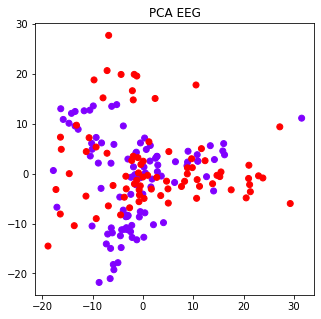

In [26]:
plt.figure(figsize=(5,5))
plt.title("PCA EEG")

# apply principal component analysis
pca = PCA(n_components=2)
pipe = make_pipeline(StandardScaler(), pca)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')

# TSNE

Text(0.5, 1.0, 'EEG tSNE')

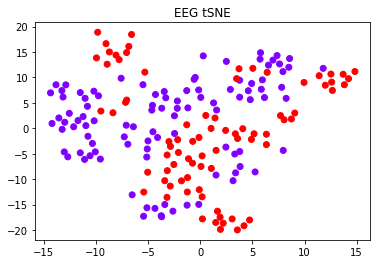

In [27]:
tsne  = sklearn.manifold.TSNE()
pipe = make_pipeline(StandardScaler(), tsne)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("EEG tSNE")

# UMAP

Text(0.5, 1.0, 'UMAP tSNE')

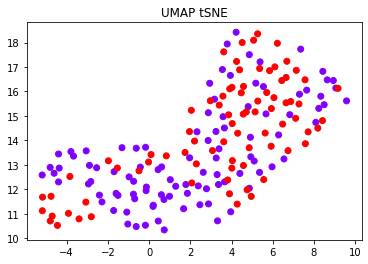

In [28]:
umap  = umap.UMAP(min_dist=0.9,n_components=2)
pipe = make_pipeline(StandardScaler(), umap)
X_2d = umap.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("UMAP tSNE")